### 0. Setup

#### 0.1. Import

In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.__version__ # verify torch version

'2.5.1+cu118'

#### 0.2. Verify GPU Access

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device type: {device}") # Verify GPU Access

Device type: cuda


### 1. Data

#### 1.1. Create a Dataset

In [3]:
w = 0.7
b = 0.3

start, end, step = 0, 1, 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = w*X + b

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

#### 1.2. Split data into training & test sets

In [4]:
train_split = int(0.8 * len(X)) # train:test = 80:20

X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

#### 1.3. Visualize data

In [5]:
def plot_predictions(train_data=X_train, 
                     train_labels=y_train, 
                     test_data=X_test, 
                     test_labels=y_test, 
                     predictions=None):
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
  
  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});

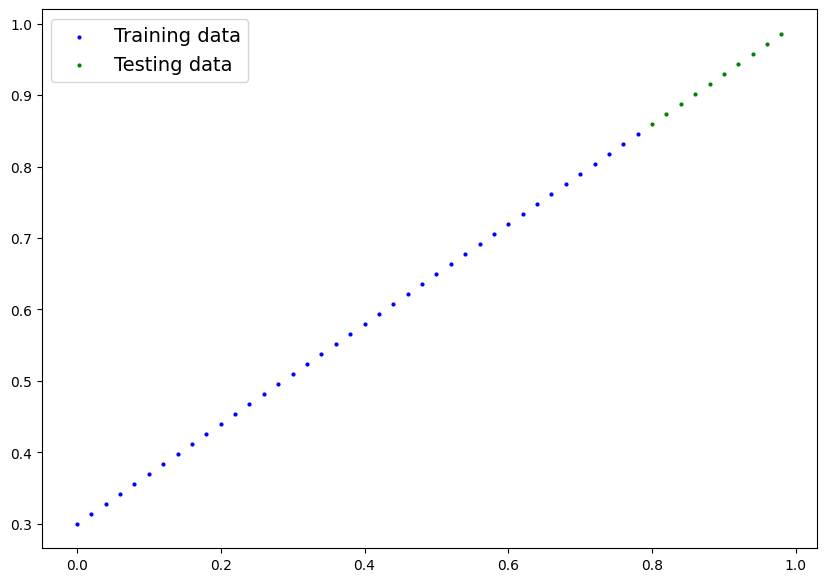

In [6]:
plot_predictions()

### 2. Build a Model

#### 2.1. Model Class Creation
**LinearRegressionModelV1**
- **Type**: Custom implementation of linear regression.
- **Components**:
  - `weights`: A trainable parameter (`nn.Parameter`) initialized with random values.
  - `bias`: A trainable parameter (`nn.Parameter`) initialized with random values.
- **Forward Method**:
  - Implements the formula: $y = \text{weights} \cdot x + \text{bias}$.
  - Requires manual definition of the linear relationship.

---

**LinearRegressionModelV2**
- **Type**: Built-in implementation using `nn.Linear`.
- **Components**:
  - `linear_layer`: A predefined linear transformation layer (`nn.Linear`) with:
    - **Input Features (`in_features`)**: 1
    - **Output Features (`out_features`)**: 1
- **Forward Method**:
  - Passes the input tensor ($x$) through the `linear_layer` for automatic computation of the linear regression.



In [7]:
class LinearRegressionModelV1(nn.Module): # subclass of nn.Module
    def __init__(self):
        super().__init__() 
        self.weights = nn.Parameter(torch.randn(1,
                                                dtype=torch.float),
                                   requires_grad=True) # update this value with gradient descent

        self.bias = nn.Parameter(torch.randn(1,
                                            dtype=torch.float),
                                requires_grad=True) # update this value with gradient descent

    def forward(self, x: torch.Tensor) -> torch.Tensor: # "x": input data
        return self.weights * x + self.bias # linear regression formula

In [8]:
class LinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer = nn.Linear(in_features=1, 
                                      out_features=1)
                                          
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)

#### 2.2. Checking contents of the model

In [9]:
torch.manual_seed(42)

model = LinearRegressionModelV2()

# 1. check its parameters
print(f"Parameter: {list(model.parameters())}")

# 2. check the model's state
print(f"State: {model.state_dict()}")

# OPTIONAL: run models on GPU
next(model.parameters()).device
model.to(device) # move to gpu
next(model.parameters()).device

Parameter: [Parameter containing:
tensor([[0.7645]], requires_grad=True), Parameter containing:
tensor([0.8300], requires_grad=True)]
State: OrderedDict([('linear_layer.weight', tensor([[0.7645]])), ('linear_layer.bias', tensor([0.8300]))])


device(type='cuda', index=0)

### 3. Training

#### 3.1. Initialize Loss Function & Optimizer

- **Loss Function**: Used `nn.L1Loss` (Mean Absolute Error) to measure the absolute differences between predictions and actual values.
- **Optimizer**: Used `torch.optim.SGD` (Stochastic Gradient Descent) with:
  - **Learning Rate**: `0.01`
  - **Parameters**: `model` parameters

In [10]:
# Create the loss function
loss_fn = nn.L1Loss()

# Create the optimizer
optimizer = torch.optim.SGD(params=model.parameters(), # model param
                            lr=0.01) # learning rate

#### 3.2. Optimization Loop

In [11]:
torch.manual_seed(42)

epochs = 1000 

train_loss_values, test_loss_values, epoch_count = [],[],[]

X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
    ### Training
    # Toggle train mode on
    model.train()
    
    # 1. Forward pass using the forward()
    y_pred = model(X_train)

    # 2. Calculate the loss
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad of the optimizer (reset! otherwise accumulates)
    optimizer.zero_grad()

    # 4. Loss backwards (backpropagation)
    loss.backward()

    # 5. Progress the optimizer (gradient descent)
    optimizer.step()

    ### Testing
    # Toggle evaluation mode on
    model.eval()
    # 1. Forward pass on test data
    with torch.inference_mode():
        test_pred = model(X_test)
    
        # 2. Calculate loss on test data
        test_loss = loss_fn(test_pred, y_test)

    if epoch % 100 == 0:
        epoch_count.append(epoch)
        train_loss_values.append(loss.detach().cpu().numpy())
        test_loss_values.append(loss.detach().cpu().numpy())
        print(f"Epoch: {epoch} | Train loss: {loss} | Test loss: {test_loss}")

Epoch: 0 | Train loss: 0.5551779866218567 | Test loss: 0.5739762187004089
Epoch: 100 | Train loss: 0.006215683650225401 | Test loss: 0.014086711220443249
Epoch: 200 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 300 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 400 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 500 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 600 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 700 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 800 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 900 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882


#### 3.3. Visualization of Epochs vs Loss

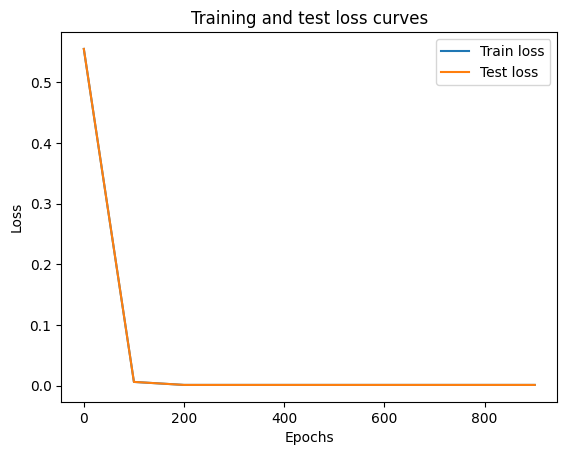

In [12]:
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

#### 3.4. Visualization of Test Performance

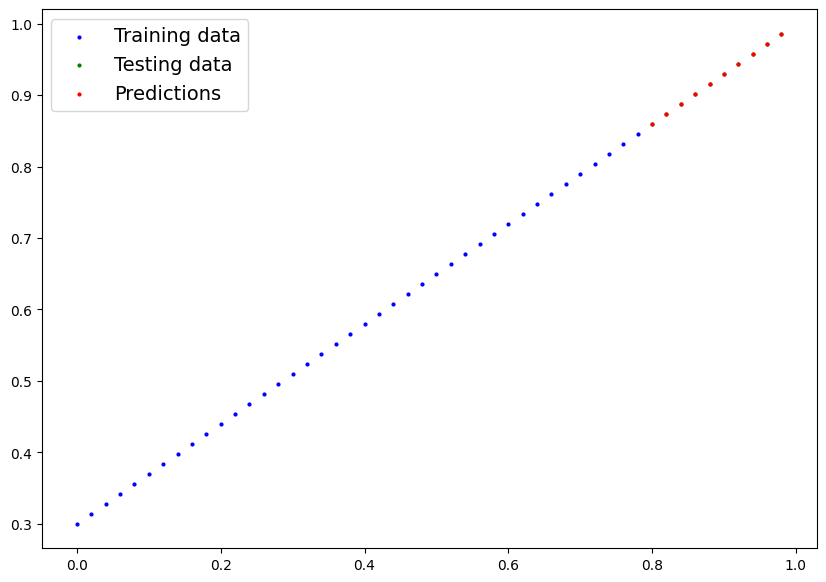

In [13]:
plot_predictions(predictions=test_pred.cpu().numpy())

### 4. Saving / Loading Model

#### 4.1. Saving a model's state (`state_dict()`)

In [14]:
from pathlib import Path

# 1. Create models directory 
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path 
MODEL_NAME = "linear_regression_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict 
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), # only saving state_dict()
           f=MODEL_SAVE_PATH) 

Saving model to: models\linear_regression_model.pth


In [15]:
!dir models /B

linear_regression_model.pth


#### 4.2. Load a model
- Assume we want to load version 1

In [16]:
loaded_model = LinearRegressionModelV2()
loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH, weights_only=True))
loaded_model.to(device) # if using gpu

LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [17]:
loaded_model.eval()
with torch.inference_mode():
    y_pred_load = loaded_model(X_test)
    
test_pred == y_pred_load # same results!

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')